In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
tf.random.set_seed(
    42
)


import seaborn as sns

tf_chkpt_path = 'tf_SGD_checkpoints/'

In [4]:
# import tensorflow as tf
# tf.config.list_physical_devices()

In [5]:
from src.helperFunctions import display_model_trainTestGraphs

# Training Set

In [6]:
# Normalizing data for 8 bit
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images/train/',
    target_size = (227,227),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 48979 images belonging to 8 classes.


# Validation Set

In [7]:
# Normalizing data for 8 bit
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227,227),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 14175 images belonging to 8 classes.


# Test Set

In [8]:
# Normalizing data for 8 bit
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'images/test/',
    target_size = (227,227),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 1793 images belonging to 8 classes.


# Modeling

In [9]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=1e-8,
                           verbose=1,
                           patience = 5,
                           restore_best_weights=True,
                           mode='min')

## Model 1 - Simple CNN

In [15]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.01),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 225, 225, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 401408)            0         
                                                                 
 dense_1 (Dense)             (None, 8)                 3211272   
                                                                 
Total params: 3,211,592
Trainable params: 3,211,592
Non-trainable params: 0
_________________________________________________________________


In [16]:
results = model.fit(train_generator,
                    callbacks=[early_stop],
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1
                    )

Epoch 1/50
383/383 [==============================] - 36s 93ms/step - loss: 0.8401 - accuracy: 0.8150 - precision_1: 0.8175 - recall_1: 0.7949 - val_loss: 0.8537 - val_accuracy: 0.7916 - val_precision_1: 0.7916 - val_recall_1: 0.7916
Epoch 2/50
383/383 [==============================] - 36s 93ms/step - loss: 0.7750 - accuracy: 0.8171 - precision_1: 0.8187 - recall_1: 0.8041 - val_loss: 0.8616 - val_accuracy: 0.7916 - val_precision_1: 0.7916 - val_recall_1: 0.7916
Epoch 3/50
383/383 [==============================] - 36s 94ms/step - loss: 0.7515 - accuracy: 0.8172 - precision_1: 0.8194 - recall_1: 0.8055 - val_loss: 0.8452 - val_accuracy: 0.7918 - val_precision_1: 0.7920 - val_recall_1: 0.7916
Epoch 4/50
383/383 [==============================] - 35s 92ms/step - loss: 0.7306 - accuracy: 0.8177 - precision_1: 0.8217 - recall_1: 0.8050 - val_loss: 0.8278 - val_accuracy: 0.7922 - val_precision_1: 0.7930 - val_recall_1: 0.7918
Epoch 5/50
383/383 [==============================] - 36s 94ms/s

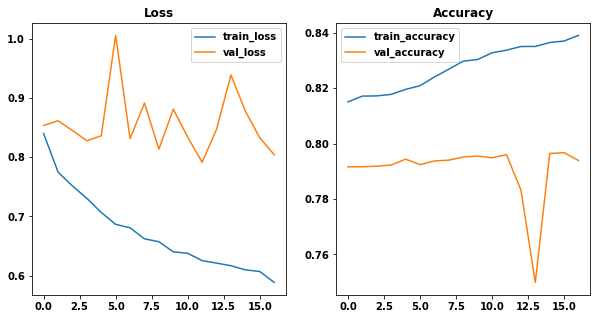

In [17]:
display_model_trainTestGraphs(results)

Validation loss from the very beginning never improved and overall accuracy went down

## Model 2

In [18]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.01),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 225, 225, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 110, 110, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 64)      

In [19]:
results = model.fit(train_generator,
                    callbacks=early_stop,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

Epoch 1/50
100/100 [==============================] - 13s 122ms/step - loss: 0.8473 - accuracy: 0.8127 - precision_2: 0.8201 - recall_2: 0.7779 - val_loss: 0.8957 - val_accuracy: 0.7914 - val_precision_2: 0.7914 - val_recall_2: 0.7914
Epoch 2/50
100/100 [==============================] - 12s 121ms/step - loss: 0.7928 - accuracy: 0.8173 - precision_2: 0.8173 - recall_2: 0.8173 - val_loss: 0.8588 - val_accuracy: 0.7934 - val_precision_2: 0.7934 - val_recall_2: 0.7934
Epoch 3/50
100/100 [==============================] - 12s 117ms/step - loss: 0.7617 - accuracy: 0.8233 - precision_2: 0.8233 - recall_2: 0.8233 - val_loss: 0.8619 - val_accuracy: 0.7895 - val_precision_2: 0.7895 - val_recall_2: 0.7895
Epoch 4/50
100/100 [==============================] - 12s 117ms/step - loss: 0.7657 - accuracy: 0.8194 - precision_2: 0.8194 - recall_2: 0.8194 - val_loss: 0.8444 - val_accuracy: 0.7906 - val_precision_2: 0.7906 - val_recall_2: 0.7906
Epoch 5/50
100/100 [==============================] - 12s 11

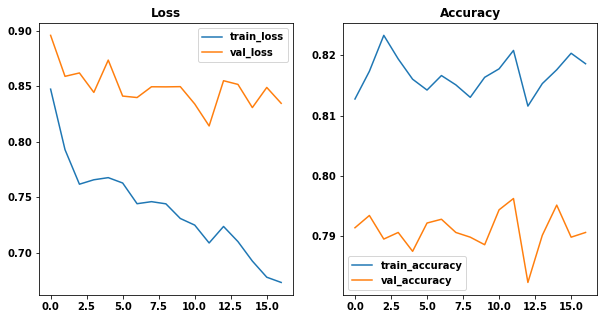

In [20]:
display_model_trainTestGraphs(results)

In [21]:
results.model.save(tf_chkpt_path+'Model_2')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_2\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_2\assets


Started overfitting really early

## Model 3

Adding additional dense layers at end

In [22]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.01),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 26, 26, 64)      

In [23]:
results = model.fit(train_generator,
                    callbacks=early_stop,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

Epoch 1/50
100/100 [==============================] - 12s 115ms/step - loss: 0.8776 - accuracy: 0.8103 - precision_3: 0.8191 - recall_3: 0.7554 - val_loss: 0.8672 - val_accuracy: 0.7953 - val_precision_3: 0.7953 - val_recall_3: 0.7953
Epoch 2/50
100/100 [==============================] - 11s 112ms/step - loss: 0.7914 - accuracy: 0.8203 - precision_3: 0.8203 - recall_3: 0.8203 - val_loss: 0.8729 - val_accuracy: 0.7880 - val_precision_3: 0.7880 - val_recall_3: 0.7880
Epoch 3/50
100/100 [==============================] - 11s 111ms/step - loss: 0.7757 - accuracy: 0.8202 - precision_3: 0.8202 - recall_3: 0.8202 - val_loss: 0.8449 - val_accuracy: 0.7942 - val_precision_3: 0.7942 - val_recall_3: 0.7942
Epoch 4/50
100/100 [==============================] - 11s 113ms/step - loss: 0.7772 - accuracy: 0.8160 - precision_3: 0.8160 - recall_3: 0.8160 - val_loss: 0.8419 - val_accuracy: 0.7936 - val_precision_3: 0.7936 - val_recall_3: 0.7936
Epoch 5/50
100/100 [==============================] - 11s 11

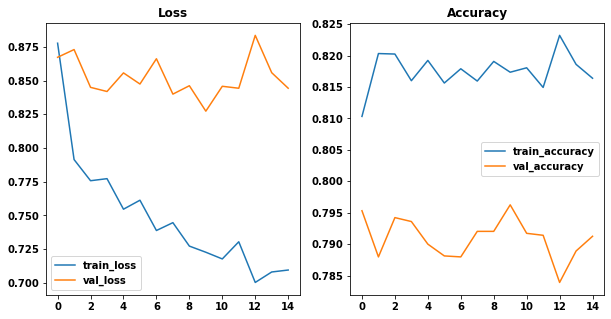

In [24]:
display_model_trainTestGraphs(results)

In [25]:
results.model.save(tf_chkpt_path+'Model_3')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_3\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_3\assets


No appreciable reduction in loss

## Model 4: DNN

Adding an extra layer of conv+maxpooling

In [26]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.01),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 64)      

In [27]:
results = model.fit(train_generator,
                    callbacks=early_stop,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

Epoch 1/50
100/100 [==============================] - 12s 114ms/step - loss: 0.9009 - accuracy: 0.8094 - precision_4: 0.8178 - recall_4: 0.7443 - val_loss: 0.8968 - val_accuracy: 0.7895 - val_precision_4: 0.7895 - val_recall_4: 0.7895
Epoch 2/50
100/100 [==============================] - 11s 110ms/step - loss: 0.7935 - accuracy: 0.8200 - precision_4: 0.8200 - recall_4: 0.8198 - val_loss: 0.8782 - val_accuracy: 0.7925 - val_precision_4: 0.7925 - val_recall_4: 0.7925
Epoch 3/50
100/100 [==============================] - 11s 113ms/step - loss: 0.7962 - accuracy: 0.8145 - precision_4: 0.8145 - recall_4: 0.8145 - val_loss: 0.8498 - val_accuracy: 0.7920 - val_precision_4: 0.7920 - val_recall_4: 0.7920
Epoch 4/50
100/100 [==============================] - 11s 110ms/step - loss: 0.7896 - accuracy: 0.8147 - precision_4: 0.8147 - recall_4: 0.8147 - val_loss: 0.8610 - val_accuracy: 0.7880 - val_precision_4: 0.7880 - val_recall_4: 0.7880
Epoch 5/50
100/100 [==============================] - 11s 11

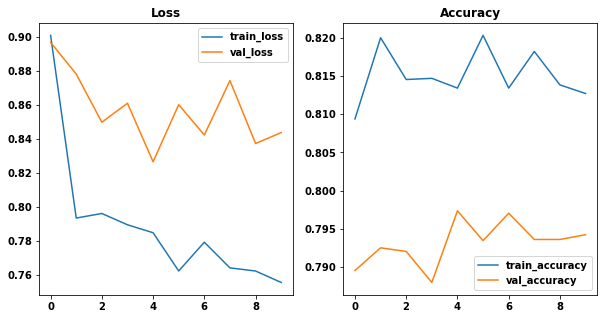

In [28]:
display_model_trainTestGraphs(results)

In [29]:
results.model.save(tf_chkpt_path+'Model_4')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_4\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_4\assets


In terms of validation loss, best performing model so far. Increasing convolutions is definitely helping. Still very over fit

## Model 5a: Adding a dropout layer and furthering depth

To help reduce overfitting adding a dropout layer at dense layer level and increasing the number of convolutions before pooling

In [30]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.01),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 53, 53, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 51, 51, 64)       

In [31]:
results = model.fit(train_generator,
                    callbacks=early_stop,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

Epoch 1/50
100/100 [==============================] - 13s 121ms/step - loss: 0.9789 - accuracy: 0.8114 - precision_5: 0.8223 - recall_5: 0.6820 - val_loss: 0.8781 - val_accuracy: 0.7934 - val_precision_5: 0.7934 - val_recall_5: 0.7934
Epoch 2/50
100/100 [==============================] - 12s 117ms/step - loss: 0.8008 - accuracy: 0.8189 - precision_5: 0.8189 - recall_5: 0.8189 - val_loss: 0.8902 - val_accuracy: 0.7866 - val_precision_5: 0.7866 - val_recall_5: 0.7866
Epoch 3/50
100/100 [==============================] - 12s 120ms/step - loss: 0.7917 - accuracy: 0.8180 - precision_5: 0.8180 - recall_5: 0.8180 - val_loss: 0.8808 - val_accuracy: 0.7862 - val_precision_5: 0.7862 - val_recall_5: 0.7862
Epoch 4/50
100/100 [==============================] - 12s 118ms/step - loss: 0.7972 - accuracy: 0.8166 - precision_5: 0.8166 - recall_5: 0.8166 - val_loss: 0.8883 - val_accuracy: 0.7877 - val_precision_5: 0.7877 - val_recall_5: 0.7877
Epoch 5/50
100/100 [==============================] - 12s 11

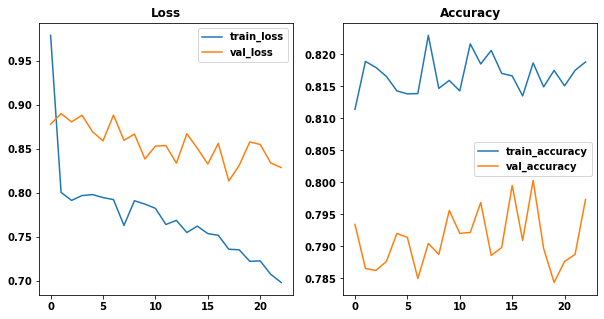

In [32]:
display_model_trainTestGraphs(results)

In [33]:
results.model.save(tf_chkpt_path+'Model_5_Dropout_02')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_5_Dropout_02\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_5_Dropout_02\assets


## Model 5b: Adding a dropout layer and furthering depth

In [34]:
# Increasing dropout rate
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.01),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 53, 53, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 51, 51, 64)       

In [35]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

Epoch 1/50
100/100 [==============================] - 13s 122ms/step - loss: 0.9517 - accuracy: 0.8094 - precision_6: 0.8181 - recall_6: 0.7073 - val_loss: 0.8834 - val_accuracy: 0.7889 - val_precision_6: 0.7889 - val_recall_6: 0.7889
Epoch 2/50
100/100 [==============================] - 12s 119ms/step - loss: 0.8125 - accuracy: 0.8155 - precision_6: 0.8155 - recall_6: 0.8155 - val_loss: 0.8988 - val_accuracy: 0.7850 - val_precision_6: 0.7850 - val_recall_6: 0.7850
Epoch 3/50
100/100 [==============================] - 12s 118ms/step - loss: 0.7702 - accuracy: 0.8241 - precision_6: 0.8241 - recall_6: 0.8241 - val_loss: 0.8668 - val_accuracy: 0.7909 - val_precision_6: 0.7909 - val_recall_6: 0.7909
Epoch 4/50
100/100 [==============================] - 12s 118ms/step - loss: 0.7906 - accuracy: 0.8181 - precision_6: 0.8181 - recall_6: 0.8181 - val_loss: 0.8657 - val_accuracy: 0.7880 - val_precision_6: 0.7880 - val_recall_6: 0.7880
Epoch 5/50
100/100 [==============================] - 12s 11

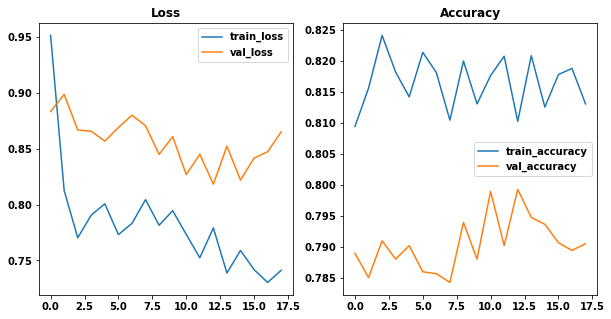

In [36]:
display_model_trainTestGraphs(results)

In [37]:
results.model.save(tf_chkpt_path+'Model_5_Dropout_05')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_5_Dropout_05\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_5_Dropout_05\assets


The higher level of dropout has made a pretty discernable improvement in our validation loss. After epoch 13, loss started to increase again.

Still with a validation loss of about 0.58, the model at epoch 13 is our best performing model yet.

## Even deeeeeper NN

Trying to mimic VGG 16 architecture

In [38]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer=optimizers.SGD(learning_rate=0.01),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 conv2d_26 (Conv2D)          (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 52, 52, 128)      

In [39]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

Epoch 1/50
100/100 [==============================] - 27s 238ms/step - loss: 0.9955 - accuracy: 0.8077 - precision_7: 0.8119 - recall_7: 0.6723 - val_loss: 0.9109 - val_accuracy: 0.7880 - val_precision_7: 0.7880 - val_recall_7: 0.7880
Epoch 2/50
100/100 [==============================] - 24s 235ms/step - loss: 0.7964 - accuracy: 0.8169 - precision_7: 0.8169 - recall_7: 0.8169 - val_loss: 0.8341 - val_accuracy: 0.8034 - val_precision_7: 0.8034 - val_recall_7: 0.8034
Epoch 3/50
100/100 [==============================] - 24s 235ms/step - loss: 0.7802 - accuracy: 0.8199 - precision_7: 0.8199 - recall_7: 0.8199 - val_loss: 0.8639 - val_accuracy: 0.7912 - val_precision_7: 0.7912 - val_recall_7: 0.7912
Epoch 4/50
100/100 [==============================] - 24s 235ms/step - loss: 0.7811 - accuracy: 0.8187 - precision_7: 0.8187 - recall_7: 0.8187 - val_loss: 0.8534 - val_accuracy: 0.7956 - val_precision_7: 0.7956 - val_recall_7: 0.7956
Epoch 5/50
100/100 [==============================] - 23s 23

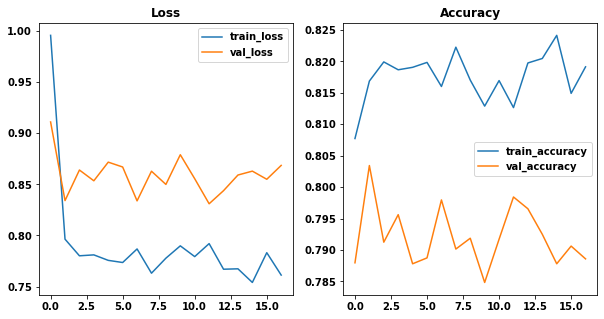

In [40]:
display_model_trainTestGraphs(results)

In [41]:
results.model.save(tf_chkpt_path+'Model_6_VGG_prototype')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_6_VGG_prototype\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_6_VGG_prototype\assets


Severe overfitting with no discernable improvement in validaiton losses or accuracy

In [42]:
# with dropout
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer=optimizers.SGD(learning_rate=0.01),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 conv2d_34 (Conv2D)          (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 52, 52, 128)      

In [43]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

Epoch 1/50
100/100 [==============================] - 25s 240ms/step - loss: 1.0155 - accuracy: 0.8075 - precision_8: 0.8174 - recall_8: 0.6637 - val_loss: 0.9028 - val_accuracy: 0.7878 - val_precision_8: 0.7878 - val_recall_8: 0.7878
Epoch 2/50
100/100 [==============================] - 24s 236ms/step - loss: 0.8090 - accuracy: 0.8176 - precision_8: 0.8175 - recall_8: 0.8175 - val_loss: 0.8475 - val_accuracy: 0.7947 - val_precision_8: 0.7947 - val_recall_8: 0.7947
Epoch 3/50
100/100 [==============================] - 24s 236ms/step - loss: 0.7724 - accuracy: 0.8225 - precision_8: 0.8225 - recall_8: 0.8225 - val_loss: 0.8444 - val_accuracy: 0.7962 - val_precision_8: 0.7962 - val_recall_8: 0.7962
Epoch 4/50
100/100 [==============================] - 24s 236ms/step - loss: 0.7947 - accuracy: 0.8171 - precision_8: 0.8171 - recall_8: 0.8171 - val_loss: 0.8221 - val_accuracy: 0.8020 - val_precision_8: 0.8020 - val_recall_8: 0.8020
Epoch 5/50
100/100 [==============================] - 24s 23

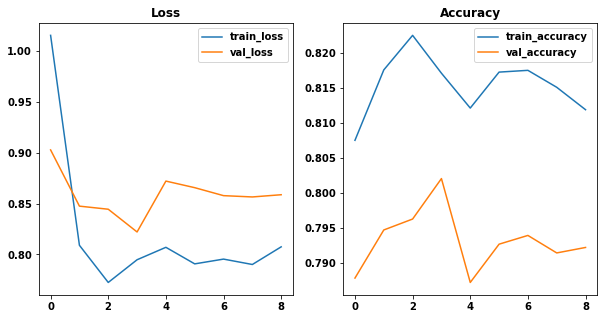

In [44]:
display_model_trainTestGraphs(results)

In [45]:
results.model.save(tf_chkpt_path+'Model_6_VGG_w_dropout')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_6_VGG_w_dropout\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_6_VGG_w_dropout\assets


Dropout clearly is making a difference.

## Model 7: Reducing conv layers per set

In [46]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.01),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 26, 26, 128)     

In [47]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

Epoch 1/50
100/100 [==============================] - 16s 148ms/step - loss: 0.9970 - accuracy: 0.8092 - precision_9: 0.8208 - recall_9: 0.6701 - val_loss: 0.9049 - val_accuracy: 0.7881 - val_precision_9: 0.7881 - val_recall_9: 0.7873
Epoch 2/50
100/100 [==============================] - 14s 144ms/step - loss: 0.8210 - accuracy: 0.8176 - precision_9: 0.8178 - recall_9: 0.8159 - val_loss: 0.8875 - val_accuracy: 0.7880 - val_precision_9: 0.7880 - val_recall_9: 0.7880
Epoch 3/50
100/100 [==============================] - 14s 143ms/step - loss: 0.8076 - accuracy: 0.8198 - precision_9: 0.8198 - recall_9: 0.8196 - val_loss: 0.8886 - val_accuracy: 0.7864 - val_precision_9: 0.7864 - val_recall_9: 0.7864
Epoch 4/50
100/100 [==============================] - 15s 145ms/step - loss: 0.8087 - accuracy: 0.8171 - precision_9: 0.8171 - recall_9: 0.8170 - val_loss: 0.8527 - val_accuracy: 0.7964 - val_precision_9: 0.7964 - val_recall_9: 0.7964
Epoch 5/50
100/100 [==============================] - 14s 14

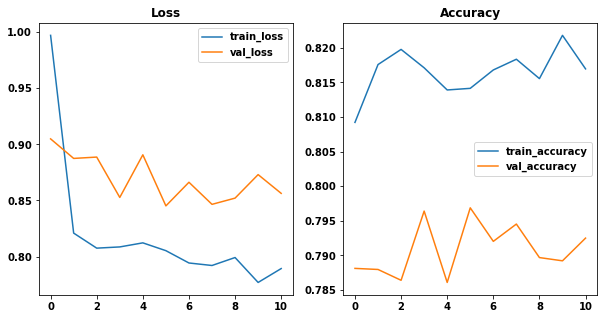

In [48]:
display_model_trainTestGraphs(results)

In [49]:
results.model.save(tf_chkpt_path+'Model_7a_VGG_1convPer')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_7a_VGG_1convPer\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_7a_VGG_1convPer\assets


Validation loss further reduced, with the lowest recorded 0.5598. And more importantly its holding and not drastically increasing again again.

### Reducing learning rate

Going to rerun the previous model, but reducing learning rate. Intuition being a more granular descent might help with the erratic validation scores.

In [50]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 26, 26, 128)    

In [51]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

Epoch 1/50
100/100 [==============================] - 19s 184ms/step - loss: 1.9844 - accuracy: 0.7661 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - val_loss: 1.8861 - val_accuracy: 0.7924 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 18s 180ms/step - loss: 1.7081 - accuracy: 0.8077 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - val_loss: 1.4296 - val_accuracy: 0.7918 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 18s 181ms/step - loss: 0.9920 - accuracy: 0.8223 - precision_10: 0.8229 - recall_10: 0.5462 - val_loss: 0.9136 - val_accuracy: 0.7927 - val_precision_10: 0.7927 - val_recall_10: 0.7927
Epoch 4/50
100/100 [==============================] - 18s 180ms/step - loss: 0.8232 - accuracy: 0.8223 - precision_10: 0.8223 - recall_10: 0.8210 - val_loss: 0.8952 - val_accuracy: 0.7941 - val_precision_10: 0.7941 - val_recall_10: 0.7941
Epoch 5/50
1

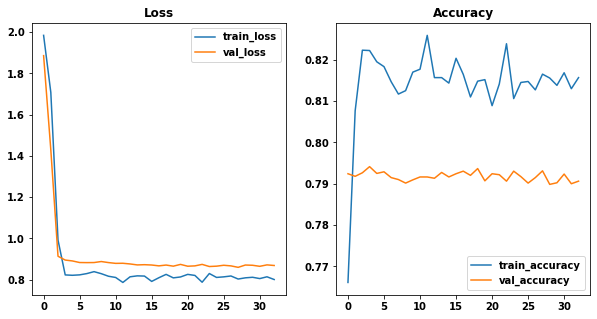

In [52]:
display_model_trainTestGraphs(results)

In [53]:
results.model.save(tf_chkpt_path+'Model_7a_VGG_1convPer')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_7a_VGG_1convPer\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_7a_VGG_1convPer\assets


Learning rate didn't have the desired/expected outcome. Althought validation losses seem to have a smoother descent

### Increasing steps per epoch

Keeping the same reduced learning rate but increasing the number of training steps per epoch

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 26, 26, 128)    

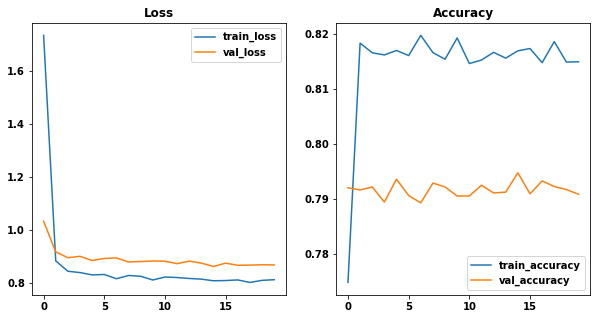

In [54]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=200,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )


display_model_trainTestGraphs(results)

Increasing the number of training samples has had a positive impact. More training examples per epoch makes for a more informed update on the weights. Overall validation loss has shown a smoother descent but also maintains around 0.55.

Lowest recorded val_loss of 0.5434

## Model 8 - Adding 1 additional convolution at a time

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 26, 26, 128)    

200/200 [==============================] - 30s 150ms/step - loss: 0.8035 - accuracy: 0.8163 - precision_12: 0.8163 - recall_12: 0.8163 - val_loss: 0.8710 - val_accuracy: 0.7911 - val_precision_12: 0.7911 - val_recall_12: 0.7911
Epoch 24/50
200/200 [==============================] - 30s 150ms/step - loss: 0.7921 - accuracy: 0.8198 - precision_12: 0.8198 - recall_12: 0.8198 - val_loss: 0.8708 - val_accuracy: 0.7912 - val_precision_12: 0.7912 - val_recall_12: 0.7912
Epoch 25/50
200/200 [==============================] - 30s 150ms/step - loss: 0.7985 - accuracy: 0.8179 - precision_12: 0.8179 - recall_12: 0.8179 - val_loss: 0.8727 - val_accuracy: 0.7898 - val_precision_12: 0.7898 - val_recall_12: 0.7898
Epoch 26/50
200/200 [==============================] - 30s 149ms/step - loss: 0.8000 - accuracy: 0.8169 - precision_12: 0.8169 - recall_12: 0.8169 - val_loss: 0.8625 - val_accuracy: 0.7932 - val_precision_12: 0.7932 - val_recall_12: 0.7932
Epoch 27/50
200/200 [==============================]

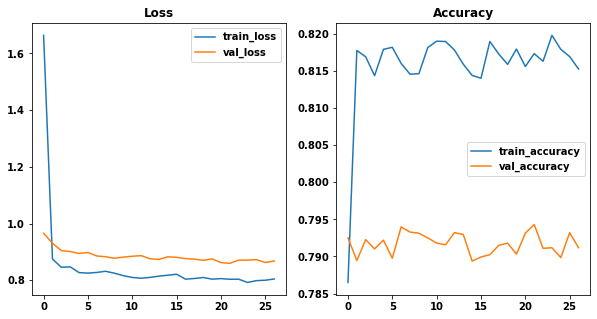

In [55]:
# one additional convolution at 512 layer
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=200,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [56]:
results.model.save(tf_chkpt_path+'Model_8')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_8\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_8\assets


Best performing model yet. Val loss was hovering around 0.5

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 26, 26, 128)    

Epoch 23/50
300/300 [==============================] - 46s 152ms/step - loss: 0.7908 - accuracy: 0.8174 - precision_13: 0.8174 - recall_13: 0.8174 - val_loss: 0.8551 - val_accuracy: 0.7930 - val_precision_13: 0.7930 - val_recall_13: 0.7930
Epoch 24/50
300/300 [==============================] - 45s 151ms/step - loss: 0.7936 - accuracy: 0.8165 - precision_13: 0.8165 - recall_13: 0.8165 - val_loss: 0.8607 - val_accuracy: 0.7911 - val_precision_13: 0.7911 - val_recall_13: 0.7911
Epoch 25/50
300/300 [==============================] - 46s 152ms/step - loss: 0.7919 - accuracy: 0.8171 - precision_13: 0.8171 - recall_13: 0.8171 - val_loss: 0.8570 - val_accuracy: 0.7917 - val_precision_13: 0.7917 - val_recall_13: 0.7917
Epoch 26/50
300/300 [==============================] - 46s 152ms/step - loss: 0.7941 - accuracy: 0.8162 - precision_13: 0.8162 - recall_13: 0.8162 - val_loss: 0.8568 - val_accuracy: 0.7918 - val_precision_13: 0.7918 - val_recall_13: 0.7918
Epoch 27/50
300/300 [===================

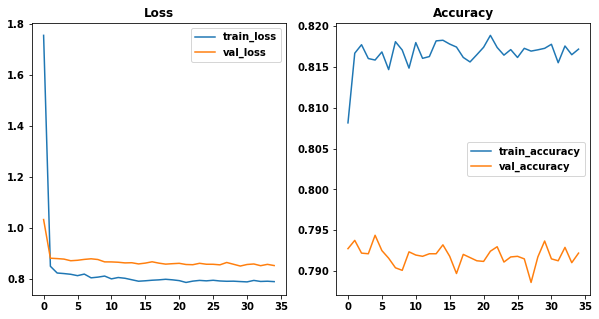

In [57]:
# one additional convolution at 512, 256 layer
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=300,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [58]:
results.model.save(tf_chkpt_path+'Model_8')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_8\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_8\assets


## Model 9

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 26, 26, 128)    

250/250 [==============================] - 39s 158ms/step - loss: 0.7882 - accuracy: 0.8191 - precision_14: 0.8191 - recall_14: 0.8191 - val_loss: 0.8610 - val_accuracy: 0.7907 - val_precision_14: 0.7907 - val_recall_14: 0.7907
Epoch 23/50
250/250 [==============================] - 39s 157ms/step - loss: 0.7948 - accuracy: 0.8174 - precision_14: 0.8174 - recall_14: 0.8174 - val_loss: 0.8549 - val_accuracy: 0.7927 - val_precision_14: 0.7927 - val_recall_14: 0.7927
Epoch 24/50
250/250 [==============================] - 39s 158ms/step - loss: 0.7907 - accuracy: 0.8176 - precision_14: 0.8176 - recall_14: 0.8176 - val_loss: 0.8606 - val_accuracy: 0.7914 - val_precision_14: 0.7914 - val_recall_14: 0.7914
Epoch 25/50
250/250 [==============================] - 39s 157ms/step - loss: 0.7892 - accuracy: 0.8182 - precision_14: 0.8182 - recall_14: 0.8182 - val_loss: 0.8528 - val_accuracy: 0.7922 - val_precision_14: 0.7922 - val_recall_14: 0.7922
Epoch 26/50
250/250 [==============================]

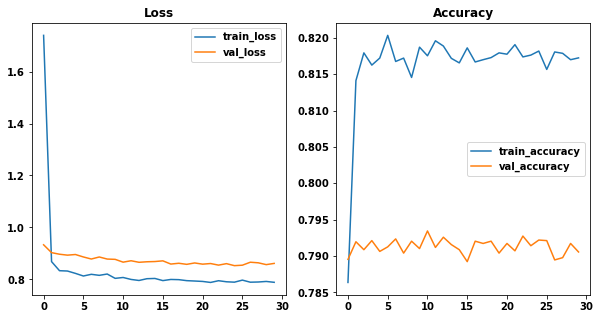

In [59]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(rate=0.3))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=250,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [60]:
results.model.save(tf_chkpt_path+'Model_9')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_9\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_9\assets


Best numbers yet. Val_loss of 0.42

## Model 10

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 conv2d_78 (Conv2D)          (None, 51, 51, 128)     

300/300 [==============================] - 52s 174ms/step - loss: 0.7938 - accuracy: 0.8164 - precision_15: 0.8164 - recall_15: 0.8164 - val_loss: 0.8635 - val_accuracy: 0.7911 - val_precision_15: 0.7911 - val_recall_15: 0.7911
Epoch 21: early stopping


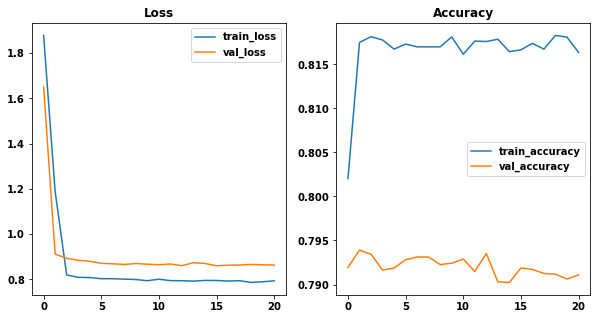

In [61]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(rate=0.5))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=300,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [62]:
results.model.save(tf_chkpt_path+'Model_10')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_10\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_10\assets


Best numbers yet. Val_loss of 0.40

## Model 11 - one more 512 conv - bad

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_83 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_84 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 conv2d_86 (Conv2D)          (None, 51, 51, 128)     

300/300 [==============================] - 53s 177ms/step - loss: 2.0677 - accuracy: 0.7388 - precision_16: 0.0000e+00 - recall_16: 0.0000e+00 - val_loss: 2.0677 - val_accuracy: 0.7928 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00
Epoch 20/50
300/300 [==============================] - 53s 177ms/step - loss: 2.0673 - accuracy: 0.7464 - precision_16: 0.0000e+00 - recall_16: 0.0000e+00 - val_loss: 2.0674 - val_accuracy: 0.7898 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00
Epoch 21/50
300/300 [==============================] - 53s 177ms/step - loss: 2.0669 - accuracy: 0.7541 - precision_16: 0.0000e+00 - recall_16: 0.0000e+00 - val_loss: 2.0669 - val_accuracy: 0.7912 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00
Epoch 22/50
300/300 [==============================] - 53s 177ms/step - loss: 2.0665 - accuracy: 0.7629 - precision_16: 0.0000e+00 - recall_16: 0.0000e+00 - val_loss: 2.0665 - val_accuracy: 0.7904 - val_precision_16: 0.0000e+00 - val_recall_16:

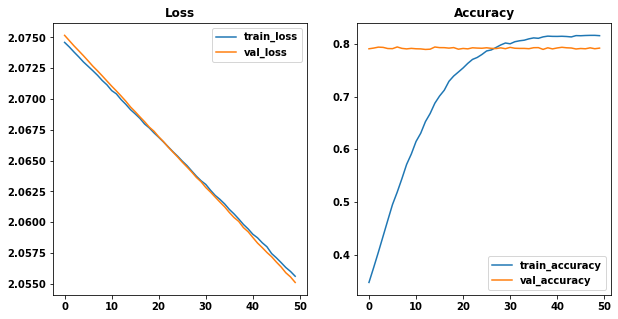

In [63]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(rate=0.5))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=1e-6),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=300,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [64]:
results.model.save(tf_chkpt_path+'Model_11')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_11\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_11\assets


## Model 12

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 conv2d_95 (Conv2D)          (None, 51, 51, 128)     

300/300 [==============================] - 53s 175ms/step - loss: 0.7928 - accuracy: 0.8168 - precision_17: 0.8168 - recall_17: 0.8168 - val_loss: 0.8588 - val_accuracy: 0.7915 - val_precision_17: 0.7915 - val_recall_17: 0.7915
Epoch 22/50
300/300 [==============================] - 52s 174ms/step - loss: 0.7880 - accuracy: 0.8177 - precision_17: 0.8177 - recall_17: 0.8177 - val_loss: 0.8604 - val_accuracy: 0.7916 - val_precision_17: 0.7916 - val_recall_17: 0.7916
Epoch 23/50
300/300 [==============================] - 53s 175ms/step - loss: 0.7965 - accuracy: 0.8159 - precision_17: 0.8159 - recall_17: 0.8159 - val_loss: 0.8621 - val_accuracy: 0.7908 - val_precision_17: 0.7908 - val_recall_17: 0.7908
Epoch 23: early stopping


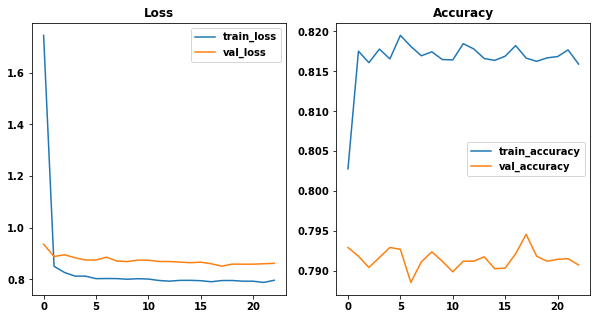

In [65]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))



model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=300,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

## Just read about Batch Normalization

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 225, 225, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 225, 225, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_101 (Conv2D)         (None, 110, 110, 64)      9280      
                                                                 
 batch_normalization_1 (Batc  (None, 110, 110, 64)     256       
 hNormalization)                                                 
                                                     

Epoch 15/50
300/300 [==============================] - 64s 213ms/step - loss: 0.3711 - accuracy: 0.8871 - precision_18: 0.9021 - recall_18: 0.8724 - val_loss: 0.7793 - val_accuracy: 0.7636 - val_precision_18: 0.8169 - val_recall_18: 0.6763
Epoch 16/50
300/300 [==============================] - 64s 213ms/step - loss: 0.3595 - accuracy: 0.8893 - precision_18: 0.9040 - recall_18: 0.8753 - val_loss: 0.6775 - val_accuracy: 0.7854 - val_precision_18: 0.8204 - val_recall_18: 0.7405
Epoch 17/50
300/300 [==============================] - 64s 213ms/step - loss: 0.3488 - accuracy: 0.8922 - precision_18: 0.9060 - recall_18: 0.8785 - val_loss: 0.7365 - val_accuracy: 0.7702 - val_precision_18: 0.8083 - val_recall_18: 0.7160
Epoch 18/50
300/300 [==============================] - 64s 213ms/step - loss: 0.3408 - accuracy: 0.8968 - precision_18: 0.9089 - recall_18: 0.8837 - val_loss: 0.7355 - val_accuracy: 0.7696 - val_precision_18: 0.8172 - val_recall_18: 0.7019
Epoch 18: early stopping


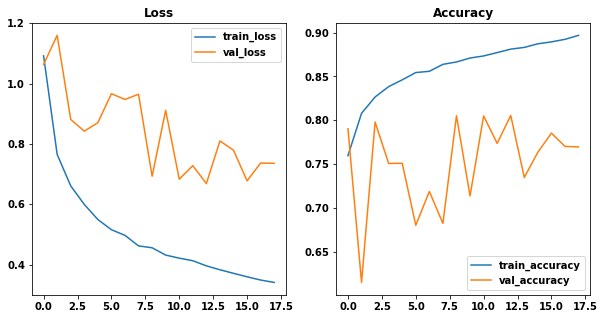

In [66]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))



model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=300,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [67]:
results.model.save(tf_chkpt_path+'Model_13_12_plus_BN')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_13_12_plus_BN\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_13_12_plus_BN\assets


## Model 14 - MOAR COMPLEXITY!

changed first layers filter to 32
3 dropout layers
- after of all convolution sets
- on first dense layer
- on second dense layer

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 225, 225, 32)      320       
                                                                 
 batch_normalization_8 (Batc  (None, 225, 225, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_109 (Conv2D)         (None, 110, 110, 64)      18496     
                                                                 
 batch_normalization_9 (Batc  (None, 110, 110, 64)     256       
 hNormalization)                                                 
                                                     

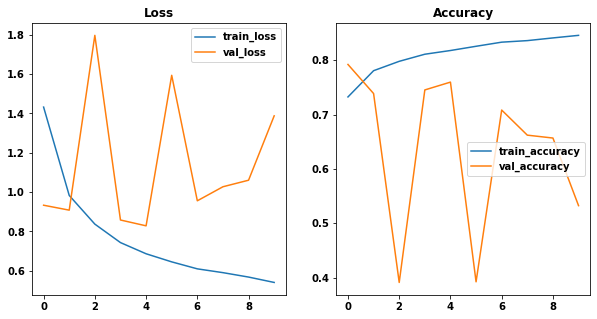

In [68]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(rate=0.5))

model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=300,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [69]:
results.model.save(tf_chkpt_path+'Model_14')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_14\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_14\assets


Removing batch normalization layers

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_116 (Conv2D)         (None, 225, 225, 32)      320       
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_117 (Conv2D)         (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_118 (Conv2D)         (None, 53, 53, 128)       73856     
                                                                 
 conv2d_119 (Conv2D)         (None, 51, 51, 128)     

Epoch 21/50
300/300 [==============================] - 60s 199ms/step - loss: 0.7919 - accuracy: 0.8170 - precision_20: 0.8170 - recall_20: 0.8170 - val_loss: 0.8657 - val_accuracy: 0.7886 - val_precision_20: 0.7886 - val_recall_20: 0.7886
Epoch 22/50
300/300 [==============================] - 60s 198ms/step - loss: 0.7878 - accuracy: 0.8180 - precision_20: 0.8180 - recall_20: 0.8180 - val_loss: 0.8577 - val_accuracy: 0.7923 - val_precision_20: 0.7923 - val_recall_20: 0.7923
Epoch 23/50
300/300 [==============================] - 60s 199ms/step - loss: 0.7912 - accuracy: 0.8175 - precision_20: 0.8175 - recall_20: 0.8175 - val_loss: 0.8589 - val_accuracy: 0.7909 - val_precision_20: 0.7909 - val_recall_20: 0.7909
Epoch 23: early stopping


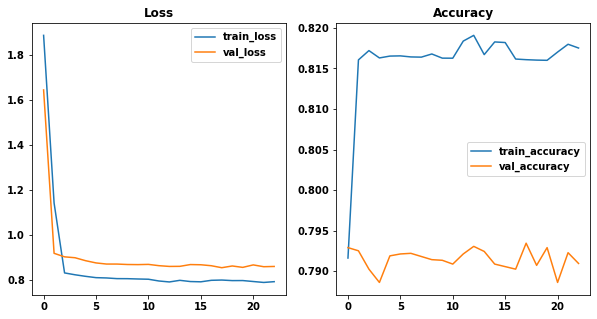

In [70]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(rate=0.5))

model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.SGD(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=300,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [71]:
results.model.save(tf_chkpt_path+'Model_14b')

INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_14b\assets


INFO:tensorflow:Assets written to: tf_SGD_checkpoints/Model_14b\assets
